In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

import csv
import itertools
import collections

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets
from torchvision import transforms
import torchvision.transforms.functional as TF
import torch.utils.data as data_utils
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [2]:
def get_train_valid_loader(data_dir,
                           batch_size,
                           augment,
                           random_seed,
                           valid_size=0.1,
                           shuffle=True):
    normalize = transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
    )

    # define transforms
    valid_transform = transforms.Compose([
            transforms.Resize((227,227)),
            transforms.ToTensor(),
            normalize,
    ])
    if augment:
        train_transform = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ])
    else:
        train_transform = transforms.Compose([
            transforms.Resize((227,227)),
            transforms.ToTensor(),
            normalize,
        ])

    # load the dataset
    train_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=train_transform,
    )

    valid_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=valid_transform,
    )

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler)

    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size, sampler=valid_sampler)

    return (train_loader, valid_loader)


def get_test_loader(data_dir,
                    batch_size,
                    shuffle=True):
    normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    )

    # define transform
    transform = transforms.Compose([
        transforms.Resize((227,227)),
        transforms.ToTensor(),
        normalize,
    ])

    dataset = datasets.CIFAR10(
        root=data_dir, train=False,
        download=True, transform=transform,
    )

    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle
    )

    return data_loader


# CIFAR10 dataset
train_loader, val_loader = get_train_valid_loader(data_dir = './data', batch_size = 64,
                       augment = False, random_seed = 1)

test_loader = get_test_loader(data_dir = './data',
                              batch_size = 64)

100%|██████████| 170498071/170498071 [00:03<00:00, 46526740.11it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


In [3]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0), # output - 96x55x55
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2)) # output - 96x27x27
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2), # output - 256x27x27
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2)) # output - 256x13x13
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1), # output - 384x13x13
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1), # output - 256x13x13
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2)) # output - 256x6x6
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(9216, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [4]:
num_classes = 10
epochs = 20
batch_size = 64
learning_rate = 0.005

teacher = AlexNet(num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(teacher.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)

In [5]:
# Load pretrained model if it is available
if os.path.exists('alexnet_pretrain.pth'):
    teacher = AlexNet(num_classes).to(device)
    # teacher.load_state_dict(torch.load('alexnet_pretrain.pth'))
    teacher = torch.load('alexnet_pretrain.pth')
else:
    for i in range(epochs):
      running_loss = 0.0
      correct = 0
      total = 0
      for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        predictions = teacher(inputs)
        loss = criterion(predictions, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        running_loss += loss.item()
        optimizer.step()

      # Finding out training loss
      train_loss = running_loss/len(train_loader)
      # training_loss.append(train_loss)

      print('Epoch [%d / %d] | Train Loss: %.3f |'%((i+1), epochs, train_loss), end=' ')

      # Finding out validation loss and accuracy
      running_loss = 0.0
      with torch.no_grad():
          for inputs, labels in val_loader:
              inputs, labels = inputs.to(device), labels.to(device)
              outputs = teacher(inputs)
              loss = criterion(outputs, labels)
              running_loss += loss.item()

              predictions = F.softmax(outputs, dim = 1)
              _, predicted = torch.max(predictions.data, 1)
              total += labels.size(0)
              correct += (predicted == labels).sum().item()

      val_loss = running_loss/len(val_loader)
      # validation_loss.append(val_loss)
      print(f'Validation Accuracy: {100 * correct // total} %')
      print()

    # Saving the teacher model
    # torch.save(teacher.state_dict(), 'alexnet_pretrain.pth')
    torch.save(teacher, 'alexnet_pretrain.pth')

Epoch [1 / 20] | Train Loss: 1.414 | Validation Accuracy: 57 %

Epoch [2 / 20] | Train Loss: 1.006 | Validation Accuracy: 68 %

Epoch [3 / 20] | Train Loss: 0.838 | Validation Accuracy: 72 %

Epoch [4 / 20] | Train Loss: 0.734 | Validation Accuracy: 75 %

Epoch [5 / 20] | Train Loss: 0.662 | Validation Accuracy: 76 %

Epoch [6 / 20] | Train Loss: 0.611 | Validation Accuracy: 77 %

Epoch [7 / 20] | Train Loss: 0.565 | Validation Accuracy: 79 %

Epoch [8 / 20] | Train Loss: 0.528 | Validation Accuracy: 79 %

Epoch [9 / 20] | Train Loss: 0.488 | Validation Accuracy: 79 %

Epoch [10 / 20] | Train Loss: 0.458 | Validation Accuracy: 80 %

Epoch [11 / 20] | Train Loss: 0.428 | Validation Accuracy: 81 %

Epoch [12 / 20] | Train Loss: 0.414 | Validation Accuracy: 80 %

Epoch [13 / 20] | Train Loss: 0.404 | Validation Accuracy: 80 %

Epoch [14 / 20] | Train Loss: 0.380 | Validation Accuracy: 80 %

Epoch [15 / 20] | Train Loss: 0.372 | Validation Accuracy: 82 %

Epoch [16 / 20] | Train Loss: 0.35

In [6]:
# Finding out accuracy of the model on train,val and test data
def evaluate(model, train_loader, val_loader, test_loader):
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            predictions = model(inputs)
            predictions = F.softmax(predictions, dim = 1)
            _, predicted = torch.max(predictions.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    train_acc = 100 * correct // total
    print(f'The training set accuracy is : {train_acc} %')

    correct = 0
    total = 0

    with torch.no_grad():
        for inputs,labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            predictions = model(inputs)
            predictions = F.softmax(predictions, dim = 1)
            _, predicted = torch.max(predictions.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    val_acc = 100 * correct // total
    print(f'The validation set accuracy is : {val_acc} %')

    correct = 0
    total = 0

    with torch.no_grad():
        for inputs,labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            predictions = model(inputs)
            predictions = F.softmax(predictions, dim = 1)
            _, predicted = torch.max(predictions.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    test_acc = 100 * correct // total
    print(f'The testing set accuracy is : {test_acc} %')
    
    return train_acc, val_acc, test_acc


train_acc, val_acc, test_acc = evaluate(teacher, train_loader, val_loader, test_loader)

The training set accuracy is : 91 %
The validation set accuracy is : 83 %
The testing set accuracy is : 82 %


In [7]:
# Finding out number of trainable parameters in the model architecture
def find_num_params(model):
    total_params = sum(
      param.numel() for param in model.parameters()
    )

    print("The number of trainable parameters is -", total_params)


# Finding out size of the model
def find_size_model(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()

    size_all_mb = (param_size + buffer_size) / 1024**2
    print('model size: {:.3f}MB'.format(size_all_mb))


find_num_params(teacher)
find_size_model(teacher)

The number of trainable parameters is - 58325066
model size: 222.503MB


In [8]:
class Student(nn.Module):
    def __init__(self, num_classes=10):
        super(Student, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=11, stride=4, padding=0), # output - 16x55x55
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2)) # output - 16x27x27
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=2, padding=2), # output - 32x14x14
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2)) # output - 32x6x6

        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(1152, 512),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(256, num_classes))

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [9]:
student1 = Student()
student1 = student1.to(device)

print(student1)

Student(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(11, 11), stride=(4, 4))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1152, out_features=512, bias=True)
    (2): ReLU()
  )
  (fc1): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): ReLU()
  )
  (fc2): Sequential(
    (0): Linear(in_features=256, out_features=10, bias=True)
  )
)


In [10]:
find_num_params(student1)
find_size_model(student1)

The number of trainable parameters is - 742986
model size: 2.835MB


In [11]:
num_classes = 10
epochs = 10
batch_size = 64
learning_rate = 0.005

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(student1.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)

In [12]:
# Student1 - learns entirely from the training data, no contribution of teacher network

alpha = 1.0

training_loss_1 = []
validation_loss_1 = []

for i in range(epochs):
  running_loss = 0.0
  correct = 0
  total = 0
  for inputs, labels in train_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    hard_predictions = F.softmax(student1(inputs), dim=1)
    student_loss = criterion(hard_predictions, labels)

    soft_labels = F.softmax(teacher(inputs), dim=1)
    soft_predictions = student1(inputs)
    distillation_loss = criterion(soft_predictions, soft_labels)

    loss = alpha*student_loss + (1-alpha)*distillation_loss

    optimizer.zero_grad()
    loss.backward()
    running_loss += loss.item()

    optimizer.step()

  # Finding out training loss
  train_loss = running_loss/len(train_loader)
  training_loss_1.append(train_loss)

  print('Epoch [%d / %d] | Train Loss: %.3f |'%((i+1), epochs, train_loss), end=' ')

  # Finding out validation loss and accuracy
  running_loss = 0.0
  with torch.no_grad():
      for inputs, labels in val_loader:
          inputs, labels = inputs.to(device), labels.to(device)
          outputs = student1(inputs)
          loss = criterion(outputs, labels)
          running_loss += loss.item()

          predictions = F.softmax(outputs, dim = 1)
          _, predicted = torch.max(predictions.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  val_loss = running_loss/len(val_loader)
  validation_loss_1.append(val_loss)
  print(f'Validation Accuracy: {100 * correct // total} %')
  print()

Epoch [1 / 10] | Train Loss: 2.228 | Validation Accuracy: 32 %

Epoch [2 / 10] | Train Loss: 2.098 | Validation Accuracy: 40 %

Epoch [3 / 10] | Train Loss: 2.040 | Validation Accuracy: 45 %

Epoch [4 / 10] | Train Loss: 2.011 | Validation Accuracy: 47 %

Epoch [5 / 10] | Train Loss: 1.989 | Validation Accuracy: 48 %

Epoch [6 / 10] | Train Loss: 1.971 | Validation Accuracy: 49 %

Epoch [7 / 10] | Train Loss: 1.961 | Validation Accuracy: 51 %

Epoch [8 / 10] | Train Loss: 1.954 | Validation Accuracy: 51 %

Epoch [9 / 10] | Train Loss: 1.951 | Validation Accuracy: 52 %

Epoch [10 / 10] | Train Loss: 1.941 | Validation Accuracy: 53 %



In [13]:
train_acc_1, val_acc_1, test_acc_1 = evaluate(student1, train_loader, val_loader, test_loader)

The training set accuracy is : 53 %
The validation set accuracy is : 53 %
The testing set accuracy is : 52 %


In [14]:
student2 = Student()
student2 = student2.to(device)

print(student2)

Student(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(11, 11), stride=(4, 4))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1152, out_features=512, bias=True)
    (2): ReLU()
  )
  (fc1): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): ReLU()
  )
  (fc2): Sequential(
    (0): Linear(in_features=256, out_features=10, bias=True)
  )
)


In [15]:
num_classes = 10
epochs = 10
batch_size = 64
learning_rate = 0.005

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(student2.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)

In [16]:
# Student2 - learns entirely from the teacher network, no contribution of training data

alpha = 0.0

training_loss_2 = []
validation_loss_2 = []

for i in range(epochs):
  running_loss = 0.0
  correct = 0
  total = 0
  for inputs, labels in train_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    hard_predictions = F.softmax(student2(inputs), dim=1)
    student_loss = criterion(hard_predictions, labels)

    soft_labels = F.softmax(teacher(inputs), dim=1)
    soft_predictions = student2(inputs)
    distillation_loss = criterion(soft_predictions, soft_labels)

    loss = alpha*student_loss + (1-alpha)*distillation_loss

    optimizer.zero_grad()
    loss.backward()
    running_loss += loss.item()

    optimizer.step()

  # Finding out training loss
  train_loss = running_loss/len(train_loader)
  training_loss_2.append(train_loss)

  print('Epoch [%d / %d] | Train Loss: %.3f |'%((i+1), epochs, train_loss), end=' ')

  # Finding out validation loss and accuracy
  running_loss = 0.0
  with torch.no_grad():
      for inputs, labels in val_loader:
          inputs, labels = inputs.to(device), labels.to(device)
          outputs = student2(inputs)
          loss = criterion(outputs, labels)
          running_loss += loss.item()

          predictions = F.softmax(outputs, dim = 1)
          _, predicted = torch.max(predictions.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  val_loss = running_loss/len(val_loader)
  validation_loss_2.append(val_loss)
  print(f'Validation Accuracy: {100 * correct // total} %')
  print()

Epoch [1 / 10] | Train Loss: 1.675 | Validation Accuracy: 48 %

Epoch [2 / 10] | Train Loss: 1.386 | Validation Accuracy: 51 %

Epoch [3 / 10] | Train Loss: 1.278 | Validation Accuracy: 55 %

Epoch [4 / 10] | Train Loss: 1.211 | Validation Accuracy: 58 %

Epoch [5 / 10] | Train Loss: 1.159 | Validation Accuracy: 60 %

Epoch [6 / 10] | Train Loss: 1.127 | Validation Accuracy: 61 %

Epoch [7 / 10] | Train Loss: 1.103 | Validation Accuracy: 61 %

Epoch [8 / 10] | Train Loss: 1.085 | Validation Accuracy: 61 %

Epoch [9 / 10] | Train Loss: 1.070 | Validation Accuracy: 62 %

Epoch [10 / 10] | Train Loss: 1.058 | Validation Accuracy: 62 %



In [17]:
train_acc_2, val_acc_2, test_acc_2 = evaluate(student2, train_loader, val_loader, test_loader)

The training set accuracy is : 63 %
The validation set accuracy is : 62 %
The testing set accuracy is : 62 %


In [18]:
student3 = Student()
student3 = student3.to(device)

print(student3)

Student(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(11, 11), stride=(4, 4))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1152, out_features=512, bias=True)
    (2): ReLU()
  )
  (fc1): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): ReLU()
  )
  (fc2): Sequential(
    (0): Linear(in_features=256, out_features=10, bias=True)
  )
)


In [19]:
num_classes = 10
epochs = 10
batch_size = 64
learning_rate = 0.005

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(student3.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)

In [20]:
# Student3 - learns from both the teacher network as well as training data equally

alpha = 0.5

training_loss_3 = []
validation_loss_3 = []

for i in range(epochs):
  running_loss = 0.0
  correct = 0
  total = 0
  for inputs, labels in train_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    hard_predictions = F.softmax(student3(inputs), dim=1)
    student_loss = criterion(hard_predictions, labels)

    soft_labels = F.softmax(teacher(inputs), dim=1)
    soft_predictions = student3(inputs)
    distillation_loss = criterion(soft_predictions, soft_labels)

    loss = alpha*student_loss + (1-alpha)*distillation_loss

    optimizer.zero_grad()
    loss.backward()
    running_loss += loss.item()

    optimizer.step()

  # Finding out training loss
  train_loss = running_loss/len(train_loader)
  training_loss_3.append(train_loss)

  print('Epoch [%d / %d] | Train Loss: %.3f |'%((i+1), epochs, train_loss), end=' ')

  # Finding out validation loss and accuracy
  running_loss = 0.0
  with torch.no_grad():
      for inputs, labels in val_loader:
          inputs, labels = inputs.to(device), labels.to(device)
          outputs = student3(inputs)
          loss = criterion(outputs, labels)
          running_loss += loss.item()

          predictions = F.softmax(outputs, dim = 1)
          _, predicted = torch.max(predictions.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  val_loss = running_loss/len(val_loader)
  validation_loss_3.append(val_loss)
  print(f'Validation Accuracy: {100 * correct // total} %')
  print()

Epoch [1 / 10] | Train Loss: 1.965 | Validation Accuracy: 43 %

Epoch [2 / 10] | Train Loss: 1.764 | Validation Accuracy: 50 %

Epoch [3 / 10] | Train Loss: 1.681 | Validation Accuracy: 53 %

Epoch [4 / 10] | Train Loss: 1.623 | Validation Accuracy: 56 %

Epoch [5 / 10] | Train Loss: 1.584 | Validation Accuracy: 57 %

Epoch [6 / 10] | Train Loss: 1.556 | Validation Accuracy: 61 %

Epoch [7 / 10] | Train Loss: 1.535 | Validation Accuracy: 61 %

Epoch [8 / 10] | Train Loss: 1.521 | Validation Accuracy: 62 %

Epoch [9 / 10] | Train Loss: 1.505 | Validation Accuracy: 62 %

Epoch [10 / 10] | Train Loss: 1.498 | Validation Accuracy: 62 %



In [21]:
train_acc_3, val_acc_3, test_acc_3 = evaluate(student3, train_loader, val_loader, test_loader)

The training set accuracy is : 64 %
The validation set accuracy is : 62 %
The testing set accuracy is : 62 %


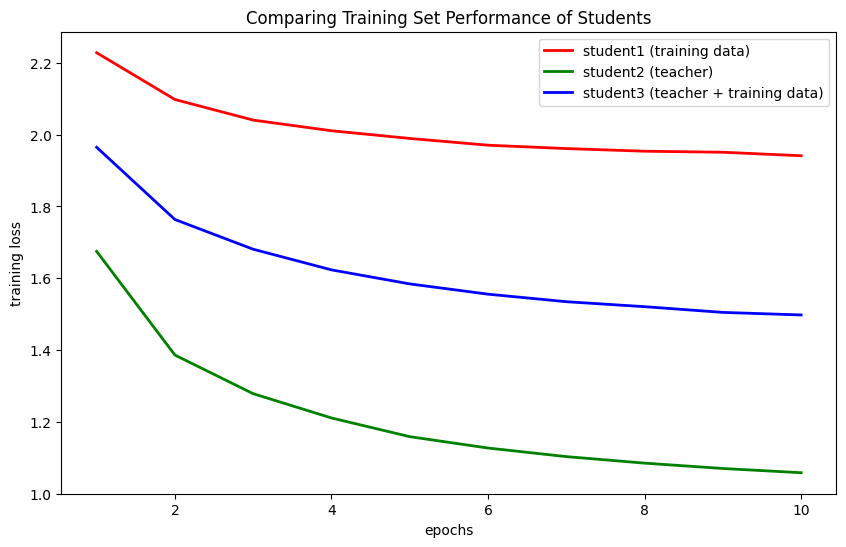

In [22]:
# Comparing the performance of the three students on training data

plt.figure(figsize=(10,6))
plt.plot([(i+1) for i in range(epochs)], training_loss_1, 'r', linewidth=2)
plt.plot([(i+1) for i in range(epochs)], training_loss_2, 'g', linewidth=2)
plt.plot([(i+1) for i in range(epochs)], training_loss_3, 'b', linewidth=2)
plt.xlabel('epochs')
plt.ylabel('training loss')
plt.legend(['student1 (training data)', 'student2 (teacher)', 'student3 (teacher + training data)'])
plt.title('Comparing Training Set Performance of Students')
plt.show()

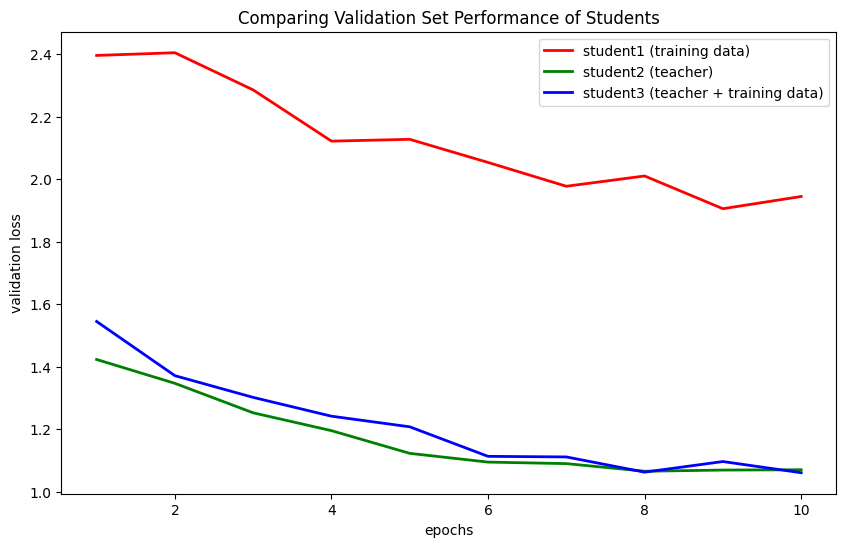

In [23]:
# Comparing the performance of the three students on validation data

plt.figure(figsize=(10,6))
plt.plot([(i+1) for i in range(epochs)], validation_loss_1, 'r', linewidth=2)
plt.plot([(i+1) for i in range(epochs)], validation_loss_2, 'g', linewidth=2)
plt.plot([(i+1) for i in range(epochs)], validation_loss_3, 'b', linewidth=2)
plt.xlabel('epochs')
plt.ylabel('validation loss')
plt.legend(['student1 (training data)', 'student2 (teacher)', 'student3 (teacher + training data)'])
plt.title('Comparing Validation Set Performance of Students')
plt.show()

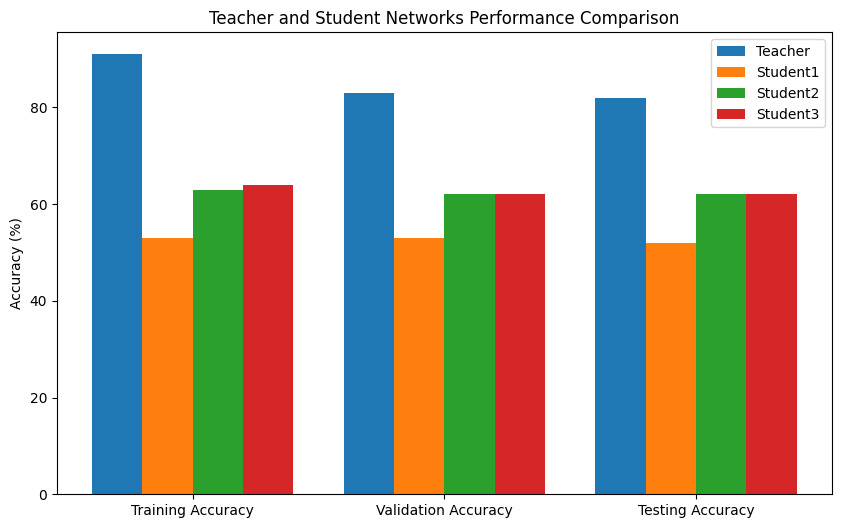

In [24]:
# Comparative evaluation of the student networks' performance against the teacher network
data = {
   'Teacher': [train_acc, val_acc, test_acc],
   'Student1': [train_acc_1, val_acc_1, test_acc_1],
   'Student2': [train_acc_2, val_acc_2, test_acc_2],
   'Student3': [train_acc_3, val_acc_3, test_acc_3],
}

labels = ['Training Accuracy', 'Validation Accuracy', 'Testing Accuracy']
bar_width = 0.2

x_pos = np.arange(len(labels))

fig, ax = plt.subplots(figsize=(10,6))

for i, (group, values) in enumerate(data.items()):
   pos = x_pos + (i * bar_width)
   ax.bar(pos, values, width=bar_width, label=group)

ax.set_xticks(x_pos + ((len(data) - 1) / 2) * bar_width)
ax.set_xticklabels(labels)

ax.legend()

ax.set_ylabel('Accuracy (%)')
ax.set_title('Teacher and Student Networks Performance Comparison')

plt.show()